<a href="https://colab.research.google.com/github/GabrielMedeiros32/An-lise-de-Fraude/blob/main/An%C3%A1liseFraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Aplicações de Métricas a modelos de detecção de Fraudes**

##**Análise Preliminar dos dados**

In [206]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [207]:
np.random.seed(73415)

In [208]:
df = pd.read_csv("/content/creditcard.csv")

In [209]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Após importarmos os dados, podemos ver que temos apenas as variáveis "Time", "Amount", e 28 outras categorias de V1 à V28. Mas porque disso? do que se tratam essa categorias?

Como especificado pelos craidores da competição no Kaggle esses dados estão passados por um transformação PCA afim de tornar esses dados anônimos, além do mais se tratam de parâmetros bancários e de pagamento de pessoas reais e que devem ter a segurança dos seus dados assegurada.

Mas o que seriam esses 28 tipos de dados então? Claro que não se pode saber, mas normalmente para casos de detecção de fraude se tratam de dados como quantas compras foram recusadas, quantos cartões diferentes são usados, quão nova é a conta ou o cliente, qual a proporção entre os tipos de pagamentos desse cliente (Ex: 50% Cartão, 25% Boleto, 25% à vista), qual a média dos gastos nas compras/contratações. Logo, é seguro presumir que esses dados contém diferentes aspectos de uma possível fraude representados neles.

Nesse caso, como não tenho nenhuma informação sobre as categorias, mas só seus valores após a transformação, tenho que assumir que todos os valores são relevantes para a análise, logo há pouca limpeza à ser feita.

In [210]:
df.isna().sum().sum()

0

In [211]:
df.dropna(inplace=True) 

Apenas alguns NaN que foram apenas retirados.

In [212]:
df.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,3.061663e-02,-2.476894e-01,1.243481e-01,-6.590202e-02,-9.875682e-02,-1.834533e-01,1.190287e-02,-7.329721e-02,9.043813e-02,2.897530e-02,-5.086602e-02,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.697350e-17,-1.424390e-15,1.755316e-17,6.391162e-17,2.398071e-16,1.991550e-15,-9.490675e-17,2.169581e-16,7.433820e-17,2.438580e-16,2.422086e-16,-2.115458e-16,9.352582e-16,-3.252451e-16,6.308789e-16,-5.011524e-16,2.870125e-16,1.818128e-16,1.036959e-16,-1.755072e-16,7.477367e-17,9.808705e-16,7.354269e-17,-9.805358e-16,-8.621897e-17,3.208233e-17,9.820892e-16,-0.227709,-0.101347
V2,-0.010593,4.697350e-17,1.000000e+00,2.512175e-16,-1.126388e-16,-2.039868e-16,5.024680e-16,3.966486e-16,-4.413984e-17,-5.728718e-17,-4.782388e-16,9.468995e-16,-6.588252e-16,3.854521e-16,-2.541036e-16,2.831060e-16,4.934097e-17,-9.883008e-16,2.636654e-16,9.528280e-17,-9.309954e-16,8.444409e-17,2.500830e-16,1.059562e-16,-8.142354e-18,-4.261894e-17,2.601622e-16,-4.478472e-16,-3.676415e-16,-0.531409,0.091289
V3,-0.419618,-1.424390e-15,2.512175e-16,1.000000e+00,-3.416910e-16,-1.436514e-15,1.431581e-15,2.168574e-15,3.433113e-16,-4.233770e-16,6.289267e-16,-5.501758e-17,2.206522e-16,-6.883375e-16,4.271336e-16,1.122756e-16,1.183364e-15,4.576619e-17,5.427965e-16,2.576773e-16,-9.429297e-16,-2.971969e-17,4.648259e-16,2.115206e-17,-9.351637e-17,4.771164e-16,6.521501e-16,6.239832e-16,7.726948e-16,-0.210880,-0.192961
V4,-0.105260,1.755316e-17,-1.126388e-16,-3.416910e-16,1.000000e+00,-1.940929e-15,-2.712659e-16,1.556330e-16,5.195643e-16,3.859585e-16,6.055490e-16,-2.083600e-16,-5.657963e-16,-1.506129e-16,-8.522435e-17,-1.507718e-16,-6.939204e-16,-4.397925e-16,1.493667e-16,-2.656938e-16,-3.223123e-16,-9.976950e-17,2.099922e-16,6.002528e-17,2.229738e-16,5.394585e-16,-6.179751e-16,-6.403423e-17,-5.863664e-17,0.098732,0.133447
V5,0.173072,6.391162e-17,-2.039868e-16,-1.436514e-15,-1.940929e-15,1.000000e+00,7.926364e-16,-4.209851e-16,7.589187e-16,4.205206e-16,-6.601716e-16,7.342759e-16,3.761033e-16,-9.578659e-16,-3.634803e-16,-5.132620e-16,-3.517076e-16,1.425729e-16,1.109525e-15,-3.138234e-16,2.076048e-16,-1.368701e-16,5.060029e-16,1.637596e-16,-9.286095e-16,5.625102e-16,9.144690e-16,4.465960e-16,-3.299167e-16,-0.386356,-0.094974
V6,-0.063016,2.398071e-16,5.024680e-16,1.431581e-15,-2.712659e-16,7.926364e-16,1.000000e+00,1.429426e-16,-1.707421e-16,1.114447e-16,2.850776e-16,4.865799e-16,2.140589e-16,-2.268061e-16,3.452801e-16,-6.368111e-18,-2.477917e-16,3.567582e-16,2.811474e-16,2.717167e-16,1.898638e-16,-1.575903e-16,-3.362902e-16,-7.232186e-17,-1.261867e-15,1.081933e-15,-2.378414e-16,-2.623818e-16,4.813155e-16,0.215981,-0.043643
V7,0.084714,1.991550e-15,3.966486e-16,2.168574e-15,1.556330e-16,-4.209851e-16,1.429426e-16,1.000000e+00,-8.691834e-17,7.933251e-16,3.043333e-17,-1.084105e-15,1.510045e-15,-9.892325e-17,-1.729462e-16,1.936832e-17,2.893672e-16,1.149692e-15,-1.116789e-16,-2.874017e-16,1.744242e-16,1.938604e-16,-1.058131e-15,2.327911e-16,-2.589727e-17,1.174169e-15,-7.334507e-16,-5.886825e-16,-6.836764e-17,0.397311,-0.187257
V8,-0.036949,-9.490675e-17,-4.413984e-17,3.433113e-16,5.195643e-16,7.589187e-16,-1.707421e-16,-8.691834e-17,1.000000e+00,2.900829e-16,9.051847e-17,1.954747e-16,-6.266057e-17,-2.382948e-16,-1.131098e-16,2.021491e-16,5.027192e-16,-3.508777e-16,-4.093852e-16,-5.339821e-16,-1.095534e-16,-2.412439e-16,5.475559e-16,3.897104e-16,-1.802967e-16,-1.390791e-16,-1.209975e-16,1.733633e-16,-4.484325e-16,-0.103079,0.019875
V9,-0.008660,2.169581e-16,-5.728718e-17,-4.233770e-16,3.859585e-16,4.205206e-16,1.114447e-16,7.933251e-16,2.900829e-16,1.000000e+00,-2.771761e-16,4.682341e-16,-2.445230e-15,-2.650351e-16,2.343317e-

O máximo que eu posso fazer é verificar a correlação cruzada de forma a encontrar se algum dos parâmetros tem a mesma "função" que algum outro, que não parece ser o caso.

## **Modelagem Primária**

In [213]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


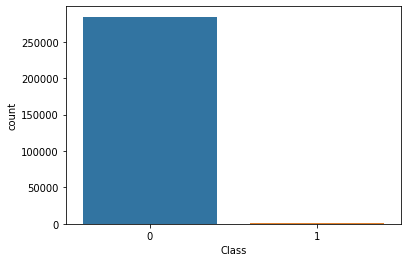

In [214]:
sns.countplot(df['Class'])

Como podemos ver estamos trabalhando com classes completamente desbalanceadas, onde as fraudes só computam 0,19% das transações.

Logo para obtermos um ótimo modelo basta fazermos o seguinte:

In [215]:
x = df.drop('Class', axis=1)
y = df['Class']

In [216]:
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y)

In [217]:
modelo = DummyClassifier(strategy="most_frequent")
modelo.fit(x_train,y_train)
y_pred = modelo.predict(x_test)

In [218]:
accuracy_score(y_test,y_pred)

0.9982725204348193

Podemos ver que conseguimos facilmente um modelo com 99,8% de acurácia, bastou apenas chutar que ninguém está tentando fraudar suas transações.

Mas a análise para por ai? Tudo que procuramos é uma alta accuracy score para o nosso modelo? E no fim das contas alguma fraude foi detectada? E se a acurácia não é a melhor medida do meu modelo?

##**Exploração de outras métricas**

Uma das primeiras coisas que aprendi quando comecei a trabalhar com modelos de Machine Learning através desse curso foram outras metricas que podem ser utilizadas, mas acima de tudo sua importância.

Outro aspecto importante dessa análise é que estou pressupondo que haja algum tipo de segunda checagem, não apenas a parte "supervisionada", mas sim algum especialista/profissional ou alguma outra checagem que venha depois de meu modelo colocar uma bandeira vermelha naquele usuário que confirme tal bandeira para de fato puni-lo com um banimento da conta por exemplo. 

Logo, se tenho alguém que vá fazer uma segunda checagem, eu não me importo de mandar pessoas que não sejam fraudadores como fraudadores em detrimento de detectar todos os fraudadores verdadeiros.

Mas qual métrica então eu deveria usar para avaliar quantos dos meus positivos são verdadeiros e quantos dos verdadeiros positivos eu retornei como verdadeiros?

Ai que entram Precision e Recall, duas métricas que buscam evidenciar exatamente isso

In [219]:
precision_score(y_test,y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [220]:
recall_score(y_test,y_pred)

0.0

Podemos ver que segundo essa métrica, o nosso modelo anterior não só não obteve a mesma proeficiência, como deixou a desejar. Po onde começar a melhorar isso?

A opção mais óbvia é começar com um modelo que tenta predizer de verdade as fraudes:

In [221]:
modelo = RandomForestClassifier()

Aqui vou usar um modelo de Random Forest não só porque, após uma rápida pesquisa, parece ser um bom modelo para esse tipo de caso, mas como é o modelo que eu quero experimentar afim de aprender.

In [222]:
modelo.fit(x_train,y_train)
y_pred = modelo.predict(x_test)

In [223]:
accuracy_score(y_test,y_pred)

0.999592708069998

In [224]:
precision_score(y_test,y_pred)

0.9433962264150944

In [225]:
recall_score(y_test,y_pred)

0.8130081300813008

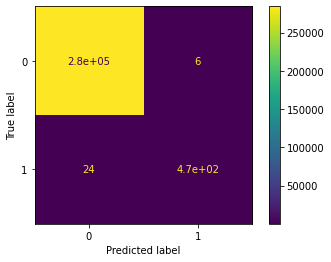

In [226]:
plot_confusion_matrix(modelo,x_test,y_test)

Logo de cara podemos ver resultados muito melhores na precisão e no recall do que no dummy anterior.

Porém, como eu disse antes, eu pressuponho uma segunda checagem, isso traduzido às métricas me diz que eu preciso de um alto recall sacrificando minha alta precisão no processo. A idéia é mudar o threshold do modelo para que ele seja menos restritivo em quem ele considera fraudulento e assim errar um pouco mais nos falsos positivos, porém, não deixar nenhum possível fraudador passar despercebido.

Como eu posso mudar isso e como eu posso avaliar essa mudança?

##**Segunda Modelagem**

In [227]:
modelo_novo = RandomForestClassifier()

In [228]:
modelo_novo.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

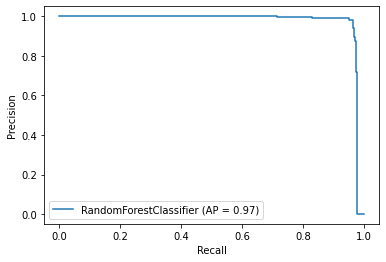

In [229]:
plot_precision_recall_curve(modelo_novo,x,y)

Aqui temos algo que é conhecido como Precision Recall Curve, que plota exatamente esse balanço entre o ganho de Recall e a perda de Precisão

Com isso eu posso executar um teste de thresholds para tentar encontrar um threshold ótimo, para isso eu vou usar a f1_score que é ainda outra métrica que trata da média geométrica entre o Recall e a Precisão.

In [230]:
thresholds = np.arange(0, 1, 0.001)

In [231]:
predicted_proba = modelo_novo.predict_proba(x_test)

In [232]:
def to_labels(predicted_proba, threshold):
	return (predicted_proba [:,1] >= threshold).astype('int')

In [233]:
scores = [f1_score(y_test, to_labels(predicted_proba, t)) for t in thresholds]

In [234]:
np.max(scores)

0.8823529411764706

In [235]:
thresholds[np.argmax(scores)]

0.391

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


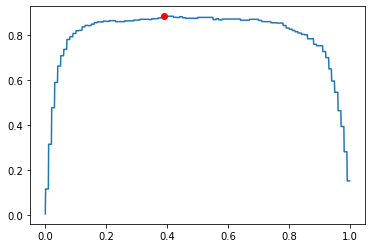

In [236]:
ax = sns.lineplot(thresholds,scores)
plt.plot(thresholds[np.argmax(scores)],np.max(scores),'ro') 

plt.show()

Dessa forma eu consegui encontrar o valor ótimo, me dando o melhor balanço entre Recall e Precision.

Porém, devo lembrar que queremos mais flexibilidade do modelo de classificar como fraude, logo, eu devo usar um valor abaixo desse ótimo que eu encontrei.

In [248]:
threshold = 0.2 #thresholds[np.argmax(scores)]
lista = []

predicted_proba = modelo_novo.predict_proba(x_test)
for i in predicted_proba:
  if i[1] >= threshold:
    lista.append(1)
  else:
    lista.append(0)
y_pred = np.array(lista)

In [242]:
recall_score(y_test,y_pred)

0.8780487804878049

In [243]:
precision_score(y_test,y_pred)

0.84375

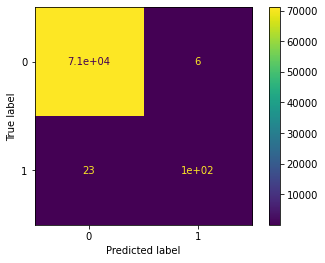

In [250]:
plot_confusion_matrix(modelo,x_test,y_test)

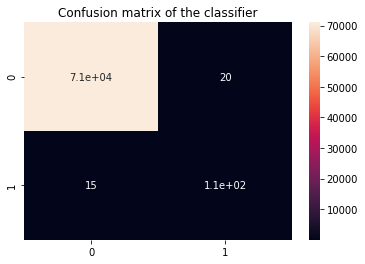

In [249]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.show()

Como podemos ver, ao compararmos os dois modelos, o segundo com o ajuste de threshold conseguiu detectar mais fraudes mesmo que acusando mais clientes "inocentes" mas ainda otimizado o suficiente para que o número de perfis à serem checados não seja exorbitante nem composto de poucos fraudadores, ou seja, conservamos uma boa precisão.